In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# Import random forest model from sklearn
from sklearn.ensemble import RandomForestRegressor
# Import decision tree model from sklearn
from sklearn.tree import DecisionTreeRegressor, plot_tree
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split 
# Standard scaler
from sklearn.preprocessing import StandardScaler, Normalizer
pd.set_option('display.max_columns', 500)

# Load final data
df_raw = pd.read_csv('data/jobs_step_1_final.csv')

#df = df[df['steps-tres-consumed-total-energy'] <= 500]

x_cols = [
    #'priority',
    'required-memory',
    'required-CPUs',
    'allocation_nodes',
    'steps-time-elapsed',
    
    'tres-allocated-cpu',
    'tres-allocated-mem',
    'tres-allocated-node',

    # # Categorical to one-hot
    # 'flags',
    # 'constraints',
    # 'state-reason',
    
    'steps-tres-requested-total-mem',
    'steps-tres-requested-total-vmem',
]

y_cols = [
    'steps-tres-consumed-total-energy',
    'steps-statistics-energy-consumed',
]

X, Y = df_raw[x_cols], df_raw[y_cols]

# #one-hot encoding
# X = pd.get_dummies(X, columns=['flags', 'constraints', 'state-reason'])


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

x_original_indices = X_test.index
y_original_indices = y_test.index


# Reset index
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

# Fit standard scaler to X
scaler = StandardScaler()
scaler.fit(X_train)

normalizer = Normalizer()
normalizer.fit(X_train)

X_train.shape

(5565, 9)

In [3]:
# # Create random forest model
hyperparams = {
    'n_estimators': 15,
    'max_depth': 10,
    'random_state': 42,
    'n_jobs': 4,
}

hyperparams1 = {
    'n_estimators': 100,
    'max_depth': 10,
    'random_state': 42,
    'n_jobs': 4,
}

model = RandomForestRegressor(**hyperparams)
model1 = RandomForestRegressor(**hyperparams1)

In [4]:
# Fit 
model = model.fit(X_train, y_train[y_cols[0]])
model1 = model1.fit(X_train, y_train[y_cols[1]])

# # Plot Random Forest
# fig, ax = plt.subplots(2,2, figsize=(20, 10))
# ax = ax.flatten()
# for i, tree in enumerate(model.estimators_):
#     plot_tree(tree, filled=True, feature_names=X_test.columns, class_names=y_cols[0], ax=ax[i])
# plt.savefig('images/random_forest.png', dpi=300)

# Print importance of features
print(f'Feature importance for Random Forest Regression for {y_cols[0]}')
print(sorted([(round(model.feature_importances_[i], 3), col) for i, col in enumerate(X_test.columns)], reverse=True))
print('-' * 50)

print(f'Feature importance for Random Forest Regression for {y_cols[1]}')
print(sorted([(round(model1.feature_importances_[i], 3), col) for i, col in enumerate(X_test.columns)], reverse=True))
print('-' * 50)

# Print test score
print('Test scores for Random Forest Regression')
print('-' * 50)
print(f'R2 Score for {y_cols[0]}: {model.score(X_test, y_test[y_cols[0]]):.4f}')
print(f'R2 Score for {y_cols[1]}: {model1.score(X_test, y_test[y_cols[1]]):.4f}')

# Calculate the absolute errors
ab_total = (model.predict(X_test) - y_test[y_cols[0]]).abs()
ab_statistic = (model1.predict(X_test) - y_test[y_cols[1]]).abs()

# Calculate the mean squared error
mse_total = ab_total**2
mse_statistic = ab_statistic**2

# Print out the mean absolute error (mae)
print('-' * 50)
print(f'Mean Absolute Error for {y_cols[0]}: {ab_total.mean():.4f} kWh')
print(f'Mean Absolute Error for {y_cols[1]}: {ab_statistic.mean():.4f} joule or {ab_statistic.mean() * (2.7778 * (10**-7)):.4f} kWh')

# Print out the mean squared error (mse)
print('-' * 50)
print(f'Mean Squared Error for {y_cols[0]}: {mse_total.mean():.4f} kWh')
print(f'Mean Squared Error for {y_cols[1]}: {mse_statistic.mean():.4f} joule or {mse_statistic.mean() * (2.7778 * (10**-7)):.4f} kWh')


# Keep in mind the standard deviation of the target variable
print('-' * 50)
print(f'Mean of {y_cols[0]}: {y_test[y_cols[0]].mean():.2f} kWh')
print(f'Standard deviation of {y_cols[0]}: {y_test[y_cols[0]].std():.2f} kWh')
print(f'Mean of {y_cols[1]}: {y_test[y_cols[1]].mean():.2f} joule or {y_test[y_cols[1]].mean() * (2.7778 * (10**-7)):.2f} kWh')
print(f'Standard deviation of {y_cols[1]}: {y_test[y_cols[1]].std():.2f} joule or {y_test[y_cols[1]].std() * (2.7778 * (10**-7)):.2f} kWh')

Feature importance for Random Forest Regression for steps-tres-consumed-total-energy
[(0.466, 'tres-allocated-mem'), (0.164, 'steps-time-elapsed'), (0.158, 'tres-allocated-node'), (0.108, 'steps-tres-requested-total-vmem'), (0.087, 'tres-allocated-cpu'), (0.009, 'required-memory'), (0.008, 'required-CPUs'), (0.001, 'allocation_nodes'), (0.0, 'steps-tres-requested-total-mem')]
--------------------------------------------------
Feature importance for Random Forest Regression for steps-statistics-energy-consumed
[(0.898, 'steps-time-elapsed'), (0.066, 'allocation_nodes'), (0.014, 'required-CPUs'), (0.01, 'tres-allocated-mem'), (0.008, 'required-memory'), (0.002, 'tres-allocated-cpu'), (0.001, 'tres-allocated-node'), (0.001, 'steps-tres-requested-total-vmem'), (0.0, 'steps-tres-requested-total-mem')]
--------------------------------------------------
Test scores for Random Forest Regression
--------------------------------------------------
R2 Score for steps-tres-consumed-total-energy: 0.

In [5]:
# Calculate baseline MAE 
baseline = y_test[y_cols[0]].mean()
baseline_statistic = y_test[y_cols[1]].mean()

# Calculate the absolute errors
ab_total_baseline = (baseline - y_test[y_cols[0]]).abs()
ab_statistic_baseline = (baseline_statistic - y_test[y_cols[1]]).abs()

# Print out the mean absolute error (mae)
print(f'Results for baseline model - simple estimator always predicting mean of target variable')
print(f'Baseline Mean Absolute Error for {y_cols[0]}: {ab_total_baseline.mean():.4f} kWh')
print(f'Baseline Mean Absolute Error for {y_cols[1]}: {ab_statistic_baseline.mean():.4f} joule or {ab_statistic_baseline.mean() * (2.7778 * (10**-7)):.4f} kWh')

# Calculate baseline MAE
baseline = y_test[y_cols[0]].median()
baseline_statistic = y_test[y_cols[1]].median()

# Calculate the absolute errors
ab_total_baseline = (baseline - y_test[y_cols[0]]).abs()
ab_statistic_baseline = (baseline_statistic - y_test[y_cols[1]]).abs()

# Print out the mean absolute error (mae)
print('-' * 50)
print(f'Results for baseline model - simple estimator always predicting median of target variable')
print(f'Baseline Mean Absolute Error for {y_cols[0]}: {ab_total_baseline.mean():.4f} kWh')
print(f'Baseline Mean Absolute Error for {y_cols[1]}: {ab_statistic_baseline.mean():.4f} joule or {ab_statistic_baseline.mean() * (2.7778 * (10**-7)):.4f} kWh')


Results for baseline model - simple estimator always predicting mean of target variable
Baseline Mean Absolute Error for steps-tres-consumed-total-energy: 42.1968 kWh
Baseline Mean Absolute Error for steps-statistics-energy-consumed: 17628711.8094 joule or 4.8969 kWh
--------------------------------------------------
Results for baseline model - simple estimator always predicting median of target variable
Baseline Mean Absolute Error for steps-tres-consumed-total-energy: 34.6458 kWh
Baseline Mean Absolute Error for steps-statistics-energy-consumed: 12225607.4727 joule or 3.3960 kWh


In [6]:
# Create a dataframe with the absolute errors
ab = pd.DataFrame({
    'Predicted_for_total-energy': model.predict(X_test),
    'Predicted_for_statistics-energy': model1.predict(X_test),
    'Error_total-energy': model.predict(X_test) - y_test[y_cols[0]],
    'Error_statistics-energy': model1.predict(X_test) - y_test[y_cols[1]],
    'Abs_err_for_total-energy': ab_total, 
    'Abs_err_for_statistics-energy': ab_statistic,
    'Mse_for_total-energy': mse_total,
    'Mse_for_statistics-energy': mse_statistic,
    })

print(ab.shape)
# Add the absolute errors and X_Test to new dataframe
ab = pd.concat([ab, X_test], axis=1).reset_index(drop=True)
print(ab.shape)
ab.head(10)

(1392, 8)
(1392, 17)


,Predicted_for_total-energy,Predicted_for_statistics-energy,Error_total-energy,Error_statistics-energy,Abs_err_for_total-energy,Abs_err_for_statistics-energy,Mse_for_total-energy,Mse_for_statistics-energy,required-memory,required-CPUs,allocation_nodes,steps-time-elapsed,tres-allocated-cpu,tres-allocated-mem,tres-allocated-node,steps-tres-requested-total-mem,steps-tres-requested-total-vmem
0,178.794348,2.938346e+05,6.794348,-1.258534e+05,6.794348,1.258534e+05,46.163168,1.583908e+10,122880.0,28.0,1.0,1230.0,28.0,122880.0,1.0,0.0,4468736.0
1,156.465992,5.097437e+05,-63.534008,-2.087263e+05,63.534008,2.087263e+05,4036.570215,4.356665e+10,102400.0,28.0,1.0,3048.0,28.0,102400.0,1.0,0.0,4468736.0
2,166.646999,6.981440e+05,-10.353001,-1.905440e+05,10.353001,1.905440e+05,107.184629,3.630702e+10,122880.0,28.0,1.0,2559.0,28.0,122880.0,1.0,0.0,4468736.0
3,146.025218,3.403763e+06,10.025218,-1.326150e+05,10.025218,1.326150e+05,100.504992,1.758673e+10,2048.0,24.0,1.0,10870.0,24.0,49152.0,1.0,0.0,4468736.0
4,166.442229,5.202736e+05,-0.557771,5.135565e+03,0.557771,5.135565e+03,0.311109,2.637403e+07,122880.0,28.0,1.0,2979.0,28.0,122880.0,1.0,0.0,4468736.0
5,141.473349,1.470408e+07,-6.526651,4.884587e+05,6.526651,4.884587e+05,42.597168,2.385919e+11,102400.0,28.0,1.0,56889.0,28.0,102400.0,1.0,0.0,4468736.0
6,200.309671,1.793023e+07,-75.690329,-1.050314e+06,75.690329,1.050314e+06,5729.025925,1.103160e+12,102400.0,28.0,1.0,116210.0,24.0,122880.0,1.0,0.0,4468736.0
7,155.222284,5.097437e+05,19.222284,5.848374e+04,19.222284,5.848374e+04,369.496191,3.420347e+09,102400.0,28.0,1.0,3138.0,28.0,102400.0,1.0,49152.0,4468736.0
8,143.640247,9.621550e+07,3.640247,-2.622812e+06,3.640247,2.622812e+06,13.251400,6.879144e+12,122880.0,28.0,1.0,316808.0,28.0,122880.0,1.0,0.0,4468736.0
9,158.620932,5.097437e+05,22.620932,4.516374e+04,22.620932,4.516374e+04,511.706556,2.039763e+09,102400.0,28.0,1.0,3154.0,28.0,102400.0,1.0,0.0,4468736.0


<AxesSubplot: >

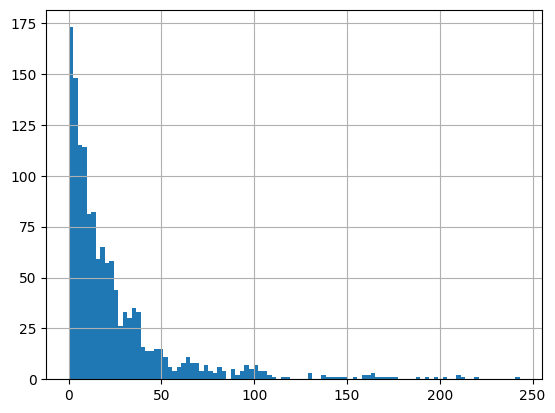

In [7]:
ab['Abs_err_for_total-energy'].hist(bins=100)

In [8]:
# Cluster the test data
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)


# Create a KMeans model with 2 clusters: model
kmans = KMeans(n_clusters=3, random_state=42)
kmans.fit(X_test_normalized)

# Use the .predict() method to predict the labels of X: labels
labels = kmans.predict(X_test_normalized)

# Calculate the silhouette_score
silhouette = silhouette_score(X_test_normalized, labels)
print(f'Silhouette score: {silhouette:.3f}')

# Print sizes of each cluster
print(f'Cluster sizes: {np.bincount(labels)}')

Silhouette score: 0.946
Cluster sizes: [1386    2    4]


c:\ProgramData\Anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
# CLuster the test data with DBSCAN to find outliers
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_test_normalized)
dbscan_labels = dbscan.labels_

# Calculate the silhouette_score
silhouette = silhouette_score(X_test_normalized, dbscan_labels)
print(f'Silhouette score: {silhouette:.3f}')

# Print sizes of each cluster not using bincount
print(f'Cluster sizes: {np.unique(dbscan_labels, return_counts=True)}')

Silhouette score: 0.687
Cluster sizes: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64), array([ 63, 392, 731,  10,  93,  47,  14,   6,  10,  19,   7], dtype=int64))


PCA explained variance: [0.32231838 0.14700241]. Sum: 0.46932078994606613
(1392, 19)


Text(0.5, 0.98, 'On PCA two components')

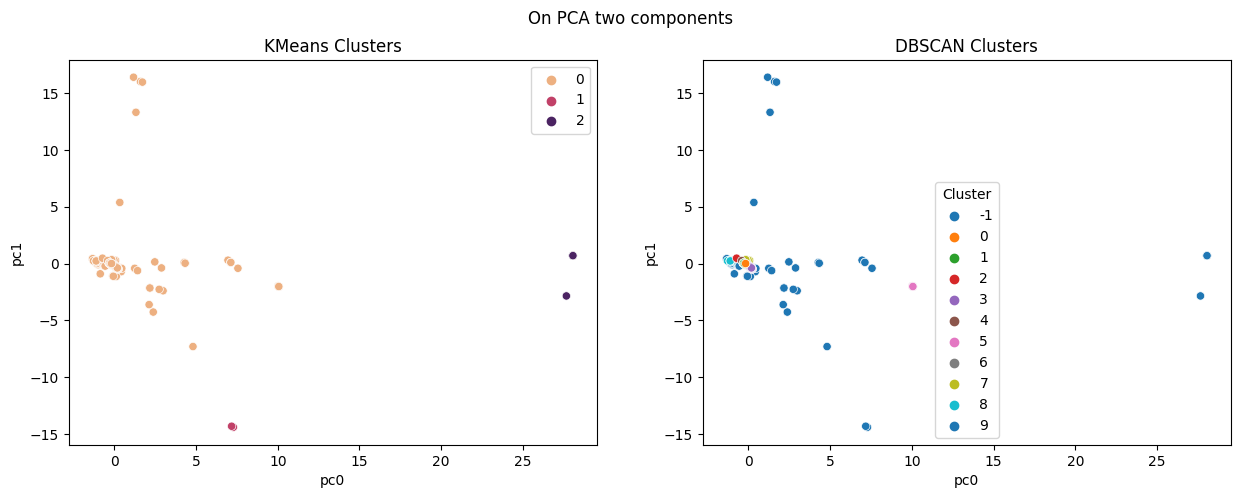

In [10]:
# Now we will try to visualize the clusters in 2D
from sklearn.decomposition import PCA, KernelPCA
import seaborn as sns
import matplotlib.pyplot as plt

# Create a PCA instance: pca
pca = PCA(n_components=2)

# Fit the PCA instance to the samples
pca.fit(X_train_normalized)

# Transform the samples: pca_features
pca_features = pca.transform(X_test_normalized)

# Print how much of the variance is explained by the first two components
print(f'PCA explained variance: {pca.explained_variance_ratio_}. Sum: {sum(pca.explained_variance_ratio_)}')

# Create KPCA instance
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15, n_jobs=-1)

# Fit the KPCA instance to the samples
kpca.fit(X_train_normalized)

# Transform the samples: kpca_features
kpca_features = kpca.transform(X_test_normalized)

to_print = 'PCA'

# Create a DataFrame with the two columns: df
if to_print == 'PCA':
    df = pd.DataFrame(pca_features, columns=['pc0', 'pc1']).reset_index(drop=True)
else:
    df = pd.DataFrame(kpca_features, columns=['pc0', 'pc1']).reset_index(drop=True)
df = pd.concat([df, ab], axis=1)
print(df.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Create a scatter plot of the two columns
sns.scatterplot(x='pc0', y='pc1', data=df, hue=labels, palette='flare', ax=ax[0])
ax[0].set_title('KMeans Clusters')

# Create a scatter plot of the two columns with DBSCAN
sns.scatterplot(x='pc0', y='pc1', data=df, hue=dbscan_labels, palette='tab10', ax=ax[1])
ax[1].set_title('DBSCAN Clusters')

# Add label to legend
plt.legend(title='Cluster')
plt.suptitle(f'On {"PCA" if to_print == "PCA" else "KPCA"} two components')

In [11]:
df[(df['pc0'] > 1 * 1e6) | (df['pc1'] > 1 * 1e6)][df.columns.tolist()[8:]]

,Mse_for_total-energy,Mse_for_statistics-energy,required-memory,required-CPUs,allocation_nodes,steps-time-elapsed,tres-allocated-cpu,tres-allocated-mem,tres-allocated-node,steps-tres-requested-total-mem,steps-tres-requested-total-vmem


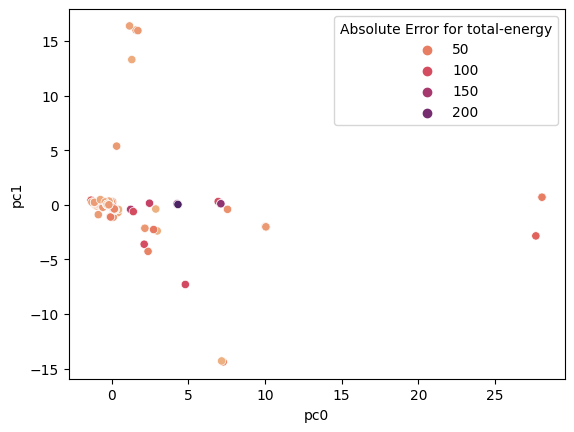

In [12]:
# Visualize test absolute errors on principal components

# Create a scatter plot of the two columns
sns.scatterplot(x='pc0', y='pc1', data=df, hue='Abs_err_for_total-energy', palette='flare')
# Add label to legend
plt.legend(title='Absolute Error for total-energy')

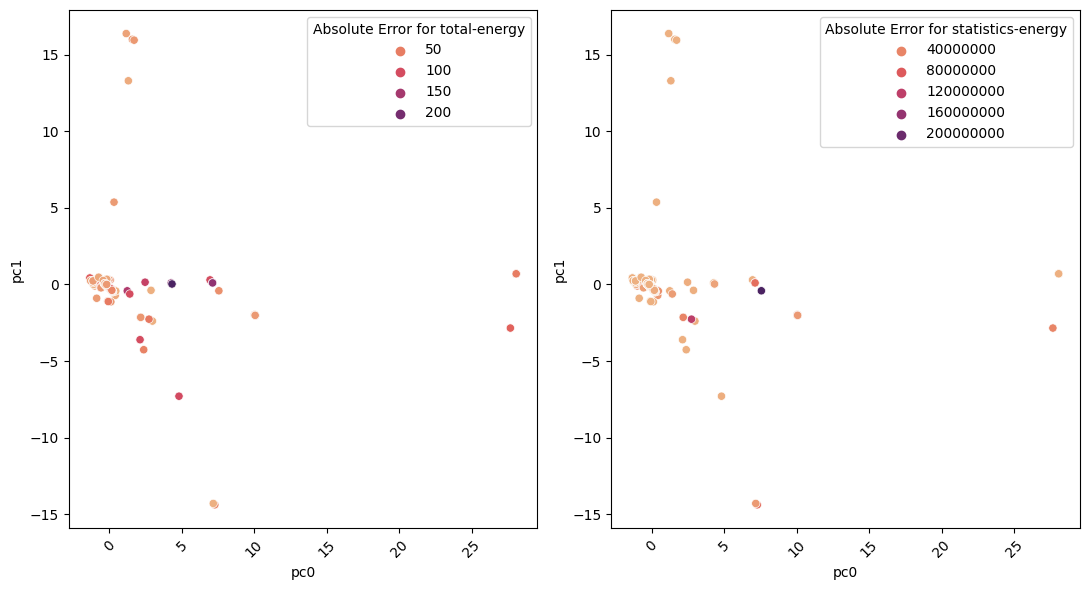

In [13]:
# Plot errors for both targets on the same plot dependent on the principal components
fig, ax = plt.subplots(1, 2, figsize=(11, 6))
sns.scatterplot(x='pc0', y='pc1', data=df, hue='Abs_err_for_total-energy', palette='flare', ax=ax[0])
sns.scatterplot(x='pc0', y='pc1', data=df, hue='Abs_err_for_statistics-energy', palette='flare', ax=ax[1])
# Add label to legend
ax[0].legend(title='Absolute Error for total-energy')
ax[1].legend(title='Absolute Error for statistics-energy')

# Rotate xticks for better readability
plt.setp(ax[0].get_xticklabels(), rotation=45)
plt.setp(ax[1].get_xticklabels(), rotation=45)

plt.tight_layout()

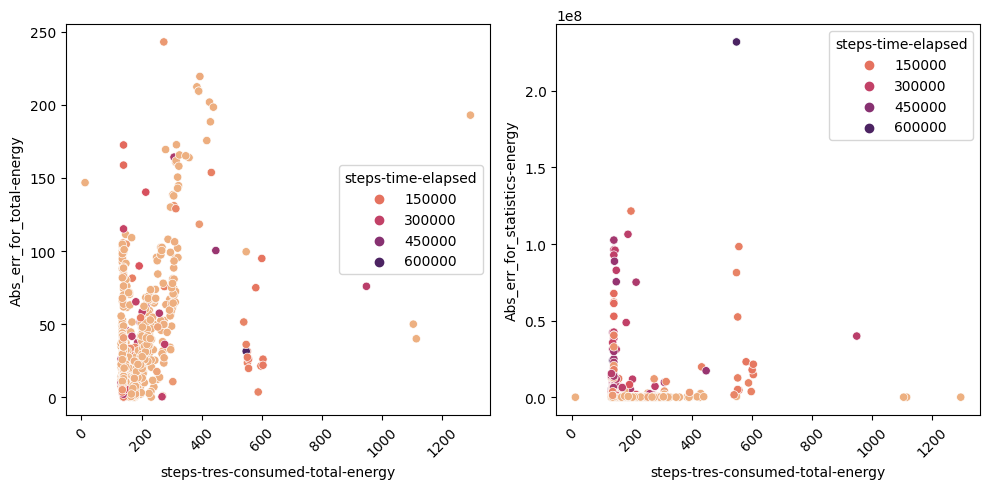

In [14]:
# Plot errors for both targets as y on the same plot dependent on steps-time-elapsed as x
_df = pd.concat([ab, y_test], axis=1).reset_index(drop=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
hue = 'steps-time-elapsed'
x = 'steps-tres-consumed-total-energy'
y = 'Abs_err_for_total-energy'
sns.scatterplot(x=x, y=y, data=_df, hue=hue, palette='flare', ax=ax[0])
y = 'Abs_err_for_statistics-energy'
sns.scatterplot(x=x, y=y, data=_df, hue=hue, palette='flare', ax=ax[1])

# Rotate xticks for better readability
plt.setp(ax[0].get_xticklabels(), rotation=45)
plt.setp(ax[1].get_xticklabels(), rotation=45)

plt.tight_layout()


3D visualizations

In [15]:
# 3D pca 
pca3d = PCA(n_components=3)
pca3d.fit(X_test_normalized)
pca3d_features = pca3d.transform(X_test_normalized)

# Print how much of the variance is explained by the first two components
print(f'PCA explained variance: {pca3d.explained_variance_ratio_}. Sum: {sum(pca3d.explained_variance_ratio_)}')

# 3D kpca 
kpca3d = KernelPCA(n_components=3, kernel='rbf', gamma=15, n_jobs=2)
kpca3d.fit(X_train_normalized)
kpca3d_features = kpca3d.transform(X_test_normalized)

# Create DataFrame
df3d = pd.DataFrame(kpca3d_features, columns=['pc0', 'pc1', 'pc2']).reset_index(drop=True)

# Add absolute errors and labels
df3d = pd.concat([df3d, ab, y_test], axis=1)
print(df3d.shape)

# Plot 3D pca with plotly
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"

color_attributes = [
    # 'Abs_err_for_total-energy', 
    # 'Abs_err_for_statistics-energy', 
    # 'steps-tres-consumed-total-energy', 
    # 'steps-statistics-energy-consumed',
    # 'Predicted_for_total-energy',
    # 'Predicted_for_statistics-energy',
    # 'Error_total-energy',
    # 'Error_statistics-energy',
    'Mse_for_total-energy',
    'Mse_for_statistics-energy',
    # 'allocation_nodes',
    # 'steps-time-elapsed', 
    # 'required-memory'
    ]
for color_attri in color_attributes:
    print(f'Plotting 3D pca with {color_attri} as color attribute')
    fig = px.scatter_3d(df3d, x='pc0', y='pc1', z='pc2', color=color_attri, opacity=0.9)
    fig.update_traces(marker_size = 8)
    fig.show()

PCA explained variance: [0.33425876 0.29345818 0.10267121]. Sum: 0.730388152470472
(1392, 22)
Plotting 3D pca with Mse_for_total-energy as color attribute
Plotting 3D pca with Mse_for_statistics-energy as color attribute


Correlation

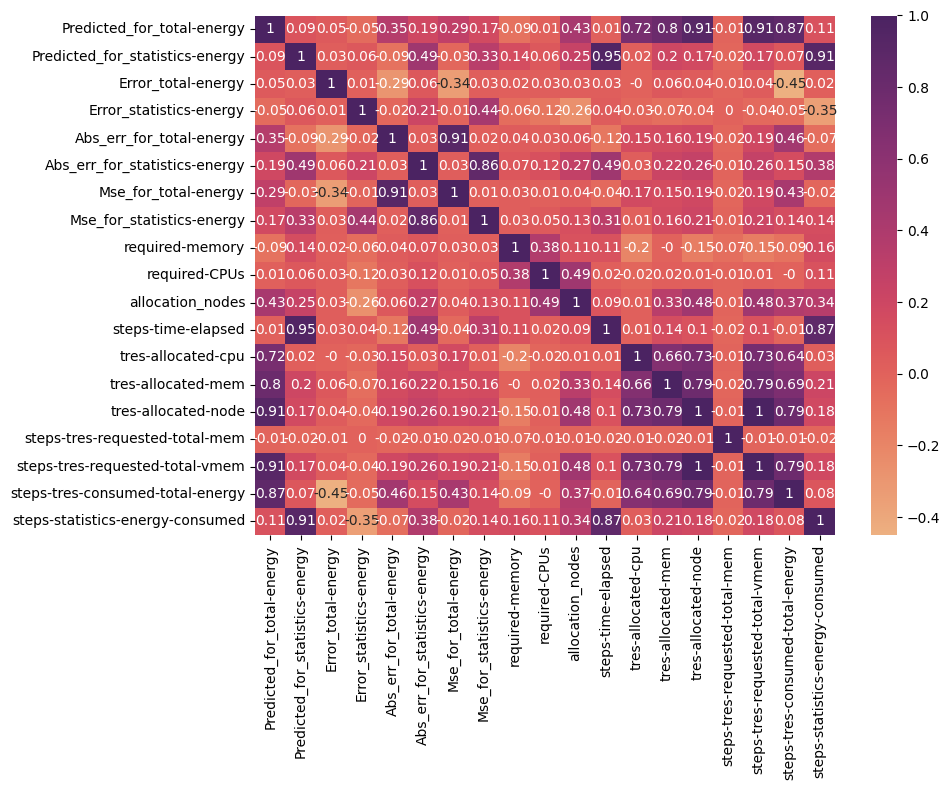

In [16]:
# Plot errors correlation with X_test features and y_test
corr_df = pd.concat([ab, y_test], axis=1)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_df.corr().round(2), annot=True, cmap='flare')
plt.tight_layout()

In [17]:
ab_sorted = pd.concat([ab, y_test], axis=1)
ab_sorted = ab_sorted.sort_values(by='Abs_err_for_total-energy', ascending=False)
ab_sorted.head(20)

,Predicted_for_total-energy,Predicted_for_statistics-energy,Error_total-energy,Error_statistics-energy,Abs_err_for_total-energy,Abs_err_for_statistics-energy,Mse_for_total-energy,Mse_for_statistics-energy,required-memory,required-CPUs,allocation_nodes,steps-time-elapsed,tres-allocated-cpu,tres-allocated-mem,tres-allocated-node,steps-tres-requested-total-mem,steps-tres-requested-total-vmem,steps-tres-consumed-total-energy,steps-statistics-energy-consumed
934,517.000000,1.198367e+07,243.000000,1.198367e+07,243.000000,1.198367e+07,59049.000000,1.436084e+14,102400.0,28.0,1.0,59056.0,96.0,196608.0,2.0,0.0,8937472.0,274.0,0.0
94,174.599115,3.951307e+06,-219.400885,-3.445010e+05,219.400885,3.445010e+05,48136.748283,1.186809e+11,122880.0,24.0,1.0,15981.0,48.0,65536.0,1.0,0.0,4468736.0,394.0,4295808.0
187,171.709876,1.488355e+05,-212.290124,1.488355e+05,212.290124,1.488355e+05,45067.096939,2.215200e+10,122880.0,28.0,1.0,581.0,28.0,122880.0,1.0,0.0,4468736.0,384.0,0.0
609,180.641240,1.489768e+05,-209.358760,-3.360918e+04,209.358760,3.360918e+04,43831.090356,1.129577e+09,122880.0,28.0,1.0,537.0,28.0,122880.0,1.0,0.0,4468736.0,390.0,182586.0
988,180.641240,1.489768e+05,-209.358760,-1.659181e+03,209.358760,1.659181e+03,43831.090356,2.752883e+06,122880.0,28.0,1.0,541.0,28.0,122880.0,1.0,0.0,4468736.0,390.0,150636.0
198,224.158241,2.484019e+06,-201.841759,-6.317704e+04,201.841759,6.317704e+04,40740.095609,3.991338e+09,122880.0,28.0,1.0,7499.0,28.0,122880.0,1.0,0.0,4468736.0,426.0,2547196.0
993,240.621272,2.666279e+06,-198.378728,-3.504767e+05,198.378728,3.504767e+05,39354.119617,1.228339e+11,122880.0,28.0,1.0,7014.0,28.0,122880.0,1.0,0.0,4468736.0,439.0,3016756.0
47,1101.066667,3.276229e+04,-192.933333,-4.032571e+04,192.933333,4.032571e+04,37223.271111,1.626163e+09,1000.0,24.0,1.0,356.0,384.0,786432.0,8.0,0.0,35749888.0,1294.0,73088.0
657,240.621272,2.517542e+06,-188.378728,2.434718e+06,188.378728,2.434718e+06,35486.545062,5.927851e+12,122880.0,28.0,1.0,7005.0,28.0,122880.0,1.0,0.0,4468736.0,429.0,82824.0
901,241.448635,2.747255e+06,-175.551365,-2.913286e+05,175.551365,2.913286e+05,30818.281827,8.487234e+10,122880.0,28.0,1.0,7108.0,28.0,122880.0,1.0,0.0,4468736.0,417.0,3038584.0


In [18]:
ab_sorted.tail(20)

,Predicted_for_total-energy,Predicted_for_statistics-energy,Error_total-energy,Error_statistics-energy,Abs_err_for_total-energy,Abs_err_for_statistics-energy,Mse_for_total-energy,Mse_for_statistics-energy,required-memory,required-CPUs,allocation_nodes,steps-time-elapsed,tres-allocated-cpu,tres-allocated-mem,tres-allocated-node,steps-tres-requested-total-mem,steps-tres-requested-total-vmem,steps-tres-consumed-total-energy,steps-statistics-energy-consumed
209,139.865667,1.731743e+07,-0.134333,-1.957096e+06,0.134333,1.957096e+06,0.018045,3.830223e+12,102400.0,28.0,1.0,115247.0,28.0,102400.0,1.0,0.0,4468736.0,140.0,19274524.0
131,139.865667,1.783209e+07,-0.134333,-2.607003e+04,0.134333,2.607003e+04,0.018045,6.796467e+08,102400.0,28.0,1.0,115574.0,28.0,102400.0,1.0,0.0,4468736.0,140.0,17858156.0
40,139.865667,1.760700e+07,-0.134333,1.010003e+06,0.134333,1.010003e+06,0.018045,1.020106e+12,102400.0,28.0,1.0,112588.0,28.0,102400.0,1.0,0.0,4468736.0,140.0,16597000.0
148,139.865667,1.761272e+07,-0.134333,-2.898514e+05,0.134333,2.898514e+05,0.018045,8.401382e+10,102400.0,28.0,1.0,112068.0,28.0,102400.0,1.0,0.0,4468736.0,140.0,17902570.0
1131,139.865667,1.793609e+07,-0.134333,1.793609e+07,0.134333,1.793609e+07,0.018045,3.217032e+14,102400.0,28.0,1.0,116685.0,28.0,102400.0,1.0,0.0,4468736.0,140.0,0.0
1102,139.865667,1.789826e+07,-0.134333,4.929885e+04,0.134333,4.929885e+04,0.018045,2.430377e+09,102400.0,28.0,1.0,115777.0,28.0,102400.0,1.0,0.0,4468736.0,140.0,17848960.0
197,139.865667,1.793609e+07,-0.134333,1.052722e+05,0.134333,1.052722e+05,0.018045,1.108224e+10,102400.0,28.0,1.0,116632.0,28.0,102400.0,1.0,0.0,4468736.0,140.0,17830814.0
1035,139.865667,1.797758e+07,-0.134333,-1.386372e+05,0.134333,1.386372e+05,0.018045,1.922028e+10,102400.0,28.0,1.0,116780.0,28.0,102400.0,1.0,0.0,4468736.0,140.0,18116222.0
1019,139.865667,1.748848e+07,-0.134333,-5.643414e+05,0.134333,5.643414e+05,0.018045,3.184812e+11,102400.0,28.0,1.0,115086.0,28.0,102400.0,1.0,0.0,4468736.0,140.0,18052822.0
1347,139.865667,1.812073e+07,-0.134333,-9.937891e+04,0.134333,9.937891e+04,0.018045,9.876167e+09,102400.0,28.0,1.0,117480.0,28.0,102400.0,1.0,0.0,4468736.0,140.0,18220110.0


In [19]:
ab_sorted[(ab_sorted['steps-time-elapsed'] > 5 * 60) & (ab_sorted['steps-time-elapsed'] < 10 * 60)].head(10)

,Predicted_for_total-energy,Predicted_for_statistics-energy,Error_total-energy,Error_statistics-energy,Abs_err_for_total-energy,Abs_err_for_statistics-energy,Mse_for_total-energy,Mse_for_statistics-energy,required-memory,required-CPUs,allocation_nodes,steps-time-elapsed,tres-allocated-cpu,tres-allocated-mem,tres-allocated-node,steps-tres-requested-total-mem,steps-tres-requested-total-vmem,steps-tres-consumed-total-energy,steps-statistics-energy-consumed
187,171.709876,148835.496048,-212.290124,148835.496048,212.290124,148835.496048,45067.096939,2.215200e+10,122880.0,28.0,1.0,581.0,28.0,122880.0,1.0,0.0,4468736.0,384.0,0.0
609,180.641240,148976.818712,-209.358760,-33609.181288,209.358760,33609.181288,43831.090356,1.129577e+09,122880.0,28.0,1.0,537.0,28.0,122880.0,1.0,0.0,4468736.0,390.0,182586.0
988,180.641240,148976.818712,-209.358760,-1659.181288,209.358760,1659.181288,43831.090356,2.752883e+06,122880.0,28.0,1.0,541.0,28.0,122880.0,1.0,0.0,4468736.0,390.0,150636.0
47,1101.066667,32762.286989,-192.933333,-40325.713011,192.933333,40325.713011,37223.271111,1.626163e+09,1000.0,24.0,1.0,356.0,384.0,786432.0,8.0,0.0,35749888.0,1294.0,73088.0
311,178.305142,148976.818712,-144.694858,40530.818712,144.694858,40530.818712,20936.601833,1.642747e+09,122880.0,28.0,1.0,562.0,28.0,122880.0,1.0,0.0,4468736.0,323.0,108446.0
1227,196.869480,71756.827681,-99.130520,-17571.172319,99.130520,17571.172319,9826.859981,3.087461e+08,2048.0,84.0,2.0,391.0,28.0,128000.0,1.0,0.0,4468736.0,296.0,89328.0
705,201.809012,148976.818712,65.809012,-15743.181288,65.809012,15743.181288,4330.826102,2.478478e+08,122880.0,28.0,1.0,514.0,28.0,122880.0,1.0,0.0,4468736.0,136.0,164720.0
460,201.809012,148976.818712,61.809012,-2859.181288,61.809012,2859.181288,3820.354003,8.174918e+06,122880.0,28.0,1.0,517.0,28.0,122880.0,1.0,0.0,4468736.0,140.0,151836.0
1379,1154.000000,30281.814088,50.000000,-39480.185912,50.000000,39480.185912,2500.000000,1.558685e+09,1000.0,24.0,1.0,327.0,384.0,786432.0,8.0,0.0,35749888.0,1104.0,69762.0
1130,188.723289,148976.818712,48.723289,-38703.181288,48.723289,38703.181288,2373.958923,1.497936e+09,122880.0,28.0,1.0,496.0,28.0,122880.0,1.0,0.0,4468736.0,140.0,187680.0


In [20]:
ab_sorted[(ab_sorted['steps-time-elapsed'] > 5 * 60) & (ab_sorted['steps-time-elapsed'] < 10 * 60)].tail(10)

,Predicted_for_total-energy,Predicted_for_statistics-energy,Error_total-energy,Error_statistics-energy,Abs_err_for_total-energy,Abs_err_for_statistics-energy,Mse_for_total-energy,Mse_for_statistics-energy,required-memory,required-CPUs,allocation_nodes,steps-time-elapsed,tres-allocated-cpu,tres-allocated-mem,tres-allocated-node,steps-tres-requested-total-mem,steps-tres-requested-total-vmem,steps-tres-consumed-total-energy,steps-statistics-energy-consumed
254,188.723289,148976.818712,-7.276711,-21183.181288,7.276711,21183.181288,52.950518,4.487272e+08,122880.0,28.0,1.0,499.0,28.0,122880.0,1.0,0.0,4468736.0,196.0,170160.0
734,169.085119,73097.820931,7.085119,4937.820931,7.085119,4937.820931,50.198913,2.438208e+07,122880.0,28.0,1.0,395.0,28.0,122880.0,1.0,0.0,4468736.0,162.0,68160.0
24,182.532359,64657.744439,6.532359,-202.255561,6.532359,202.255561,42.671708,4.090731e+04,102400.0,28.0,1.0,317.0,28.0,102400.0,1.0,0.0,4468736.0,176.0,64860.0
932,180.641240,148976.818712,-6.358760,27326.818712,6.358760,27326.818712,40.433828,7.467550e+08,122880.0,28.0,1.0,543.0,28.0,122880.0,1.0,0.0,4468736.0,187.0,121650.0
1234,163.858540,74954.295379,5.858540,302.295379,5.858540,302.295379,34.322486,9.138250e+04,122880.0,28.0,1.0,327.0,28.0,122880.0,1.0,0.0,4468736.0,158.0,74652.0
1345,163.858540,74794.796137,5.858540,-10027.203863,5.858540,10027.203863,34.322486,1.005448e+08,122880.0,28.0,1.0,340.0,28.0,122880.0,1.0,0.0,4468736.0,158.0,84822.0
893,186.465130,148976.818712,-3.534870,-6491.181288,3.534870,6491.181288,12.495303,4.213543e+07,122880.0,28.0,1.0,511.0,28.0,122880.0,1.0,0.0,4468736.0,190.0,155468.0
964,195.851094,107327.327869,-3.148906,-39240.672131,3.148906,39240.672131,9.915608,1.539830e+09,122880.0,28.0,1.0,448.0,28.0,122880.0,1.0,0.0,4468736.0,199.0,146568.0
723,182.532359,64657.744439,-2.467641,13357.744439,2.467641,13357.744439,6.089254,1.784293e+08,102400.0,28.0,1.0,306.0,28.0,102400.0,1.0,0.0,4468736.0,185.0,51300.0
706,179.114702,148976.818712,-0.885298,-34495.181288,0.885298,34495.181288,0.783753,1.189918e+09,122880.0,28.0,1.0,526.0,28.0,122880.0,1.0,0.0,4468736.0,180.0,183472.0


<AxesSubplot: >

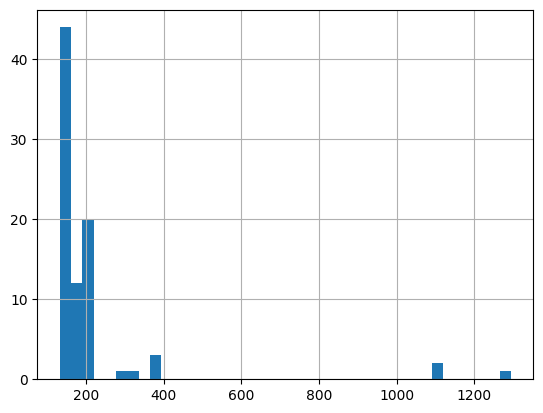

In [21]:
ab_sorted[(ab_sorted['steps-time-elapsed'] > 5 * 60) & (ab_sorted['steps-time-elapsed'] < 10 * 60)]['steps-tres-consumed-total-energy'].hist(bins=40)

<AxesSubplot: xlabel='steps-tres-consumed-total-energy', ylabel='steps-statistics-energy-consumed'>

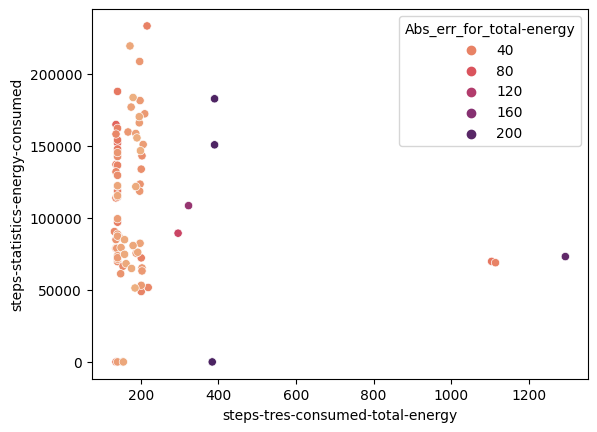

In [22]:
x = ab_sorted[(ab_sorted['steps-time-elapsed'] > 5 * 60) & (ab_sorted['steps-time-elapsed'] < 10 * 60)][[
    'steps-tres-consumed-total-energy', 
    'Abs_err_for_total-energy', 
    'steps-statistics-energy-consumed', 
    'steps-time-elapsed',
    ]]

sns.scatterplot(data=x, x='steps-tres-consumed-total-energy', hue='Abs_err_for_total-energy', y='steps-statistics-energy-consumed', palette='flare')

In [23]:
remapped = pd.concat([ab, y_test], axis=1)
remapped.index = y_original_indices
remapped = pd.concat([remapped, df_raw.iloc[y_original_indices]], axis=1)
# remove duplicated columns
remapped = remapped.loc[:,~remapped.columns.duplicated()]
# sort
remapped = remapped.sort_values(by='Abs_err_for_total-energy', ascending=False)

# convert steps time elapsed to minutes
remapped['steps-time-elapsed'] = remapped['steps-time-elapsed'].apply(lambda x: x / 60)
# rename steps-time-elapsed to steps-time-elapsed (minutes)
remapped = remapped.rename(columns={'steps-time-elapsed': 'steps-time-elapsed (minutes)'})

# convert tres-allocated-mem and required-memory to GB
remapped['tres-allocated-mem'] = remapped['tres-allocated-mem'].apply(lambda x: x / 1024)
remapped['required-memory'] = remapped['required-memory'].apply(lambda x: x / 1024)
remapped = remapped.rename(columns={'tres-allocated-mem': 'tres-allocated-mem (GB)', 'required-memory': 'required-memory (GB)'})

# convert tres-allocated-cpu and required-CPUs, allocation_nodes, tres-allocated-node, tres-allocated-mem, required-memory to int
remapped['tres-allocated-cpu'] = remapped['tres-allocated-cpu'].astype(int)
remapped['required-CPUs'] = remapped['required-CPUs'].astype(int)
remapped['allocation_nodes'] = remapped['allocation_nodes'].astype(int)
remapped['tres-allocated-node'] = remapped['tres-allocated-node'].astype(int)
remapped['tres-allocated-mem (GB)'] = remapped['tres-allocated-mem (GB)'].astype(int)
remapped['required-memory (GB)'] = remapped['required-memory (GB)'].astype(int)


# change precision of dataframe to 2 decimals
remapped = remapped.round(2)


display_cols = [
    'Predicted_for_total-energy', 
    'Error_total-energy', 
    'steps-tres-consumed-total-energy', 
    # 'Predicted_for_statistics-energy', 
    # 'Error_statistics-energy', 
    # 'Abs_err_for_total-energy', 
    # 'Abs_err_for_statistics-energy', 
    # 'steps-statistics-energy-consumed', 
    'steps-time-elapsed (minutes)', 
    'allocation_nodes', 
    'tres-allocated-node',
    'tres-allocated-mem (GB)',
    'required-memory (GB)',
    'tres-allocated-cpu',
    'required-CPUs',
    'user',
    'group',
    'nodes',
    'partition'
    ]
top_50_error = remapped[display_cols].head(50).reset_index(drop=True)
top_50_error.to_csv('data/top_50_error_radek_local.csv', index=False)
top_50_error.head(10)

,Predicted_for_total-energy,Error_total-energy,steps-tres-consumed-total-energy,steps-time-elapsed (minutes),allocation_nodes,tres-allocated-node,tres-allocated-mem (GB),required-memory (GB),tres-allocated-cpu,required-CPUs,user,group,nodes,partition
0,517.00,243.00,274.0,984.27,1,2,192,100,96,28,andrzej,users,e1498,standard
1,174.60,-219.40,394.0,266.35,1,1,64,120,48,24,plgmtyrolski,plgrid-users,e1107,plgrid
2,171.71,-212.29,384.0,9.68,1,1,120,120,28,28,andrzej,users,e1818,standard
3,180.64,-209.36,390.0,8.95,1,1,120,120,28,28,andrzej,users,e2006,standard
4,180.64,-209.36,390.0,9.02,1,1,120,120,28,28,andrzej,users,e1828,standard
5,224.16,-201.84,426.0,124.98,1,1,120,120,28,28,andrzej,users,e1359,standard
6,240.62,-198.38,439.0,116.90,1,1,120,120,28,28,andrzej,users,e2019,standard
7,1101.07,-192.93,1294.0,5.93,1,8,768,0,384,24,plgmpuchals,plgrid-users,e1175,standard
8,240.62,-188.38,429.0,116.75,1,1,120,120,28,28,andrzej,users,e2015,standard
9,241.45,-175.55,417.0,118.47,1,1,120,120,28,28,andrzej,users,e2013,standard


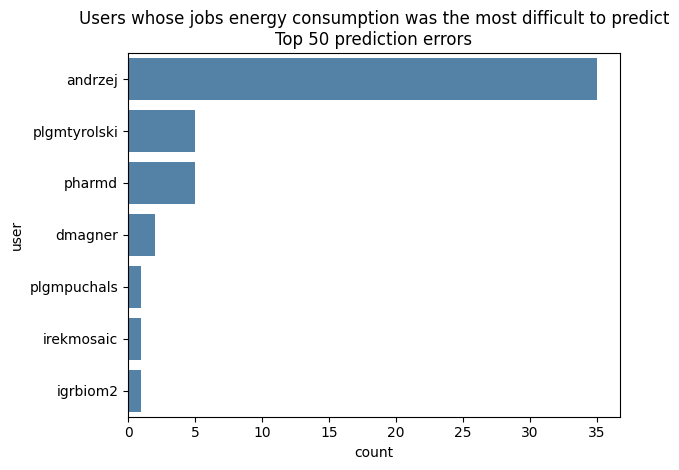

In [26]:
# Display horizontal barplot of top 50 errors that counts the number of occurences of user, group, nodes, partition
sns.countplot(y='user', data=top_50_error, order=top_50_error['user'].value_counts().index, color='steelblue')
plt.title('Users whose jobs energy consumption was the most difficult to predict\nTop 50 prediction errors')
plt.tight_layout()
plt.savefig('images/_local/top_50_error_users_radek.png', dpi=300)


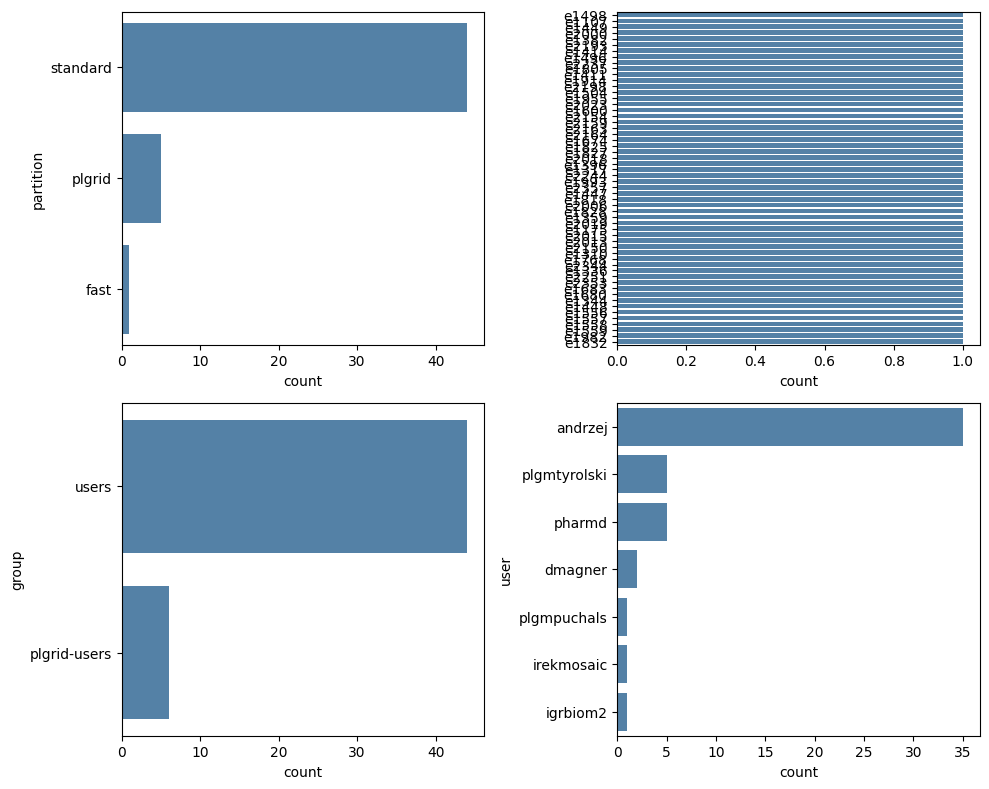

In [25]:
from admire.preprocessing.mapping_functions import extract_nodes_from_node, transform_all_nodes

nodes = []
for node_record in top_50_error['nodes']:
    nodes += extract_nodes_from_node(node_record)

# Plot counts of nodes


# Plot counts of partition, nodes, group, user
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
sns.countplot(y='partition', data=top_50_error, order=top_50_error['partition'].value_counts().index, color='steelblue', ax=ax[0, 0])
sns.countplot(y=nodes, order=pd.Series(nodes).value_counts().index, color='steelblue', ax=ax[0, 1])
sns.countplot(y='group', data=top_50_error, order=top_50_error['group'].value_counts().index, color='steelblue', ax=ax[1, 0])
sns.countplot(y='user', data=top_50_error, order=top_50_error['user'].value_counts().index, color='steelblue', ax=ax[1, 1])
plt.tight_layout()